## Library Imports

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Gaussian Mixture Model Implementation
This Gaussian Mixture Model utilizes the E-M Algorithm (Expection, Maximization) in order to calculate the probability that each data point belongs to a certain cluster using soft-clustering and then attempts to use maximization in order to update each cluster to maximize the probability of generating that data and working to create a model that is convergent. 

In [174]:
class GaussianM:
    '''
        num_components are the number of clusters that we want to split our data
        max_iter is the maximum iterations taken by our algorithm, default 50
    '''
    def __init__(self, num_clusters, max_iter = 50):
        self.num_clusters = int(num_clusters)
        self.max_iter = int(max_iter)
        
        # Cluster names for printing
        self.cluster_names = [index for index in range(self.num_clusters)]
        
        # list with fraction of the dataset
        self.pi = [1 / self.num_clusters for tmp in range(self.num_clusters)]

    def predict(self, X):
        probabilities = []
        
        for n in range(len(X)):
            probabilities.append([self.multivariate_normal(X[n], self.mean_vector[k], self.covariance_matrix[k]) for k in range(self.num_clusters)])
        
        clusters = []
        for p in probabilities:
            returned_prob = self.cluster_names[p.index(max(p))]
            clusters.append(returned_prob)
        return clusters
        
    '''
        Expectation Step: Computes probability that each datapoint should be in a certain cluster
    '''
    def e_step(self, X):
        data_length = len(X)
        
        # Responsibilities Matrix Creation (All zeroes)
        self.resp = np.zeros((len(X), self.num_clusters))
        
        # Calculating the responsibility matrix
        for i in range(data_length):
            
            for k in range(self.num_clusters):
                self.resp[i][k] = self.pi[k] * self.multivariate_normal(X[i], self.mean_vector[k], self.covariance_matrix[k])
                
                # Loop through clusters, take initial fraction, multiply with multivariate distribution vector to update responsibility matrix
                self.resp[i][k] /= sum([self.pi[j]*self.multivariate_normal(X[i], self.mean_vector[j], self.covariance_matrix[j]) for j in range(self.num_clusters)])
    
    '''
        Maximization Step: Assuming expectation is correct, change parameters of each Gaussian to maximize the probability
        that it would generate the data that it is responsible for
    '''
    def m_step(self, X):
        self.mean_vector = np.zeros((self.num_clusters, len(X[0])))
        
        for k in range(self.num_clusters):
            for n in range(len(X)):
                self.mean_vector[k] += self.resp[n][k] * X[n]
                
        self.mean_vector = [1/self.SumResp[k]*self.mean_vector[k] for k in range(self.num_clusters)]
        
        # Initiating the list of the covariance matrixes
        self.covariance_matrix = [np.zeros((len(X[0]), len(X[0]))) for k in range(self.num_clusters)]
        
        # Updating the covariance matrices
        for k in range(self.num_clusters):
            sliced = self.resp[:, k]
            self.covariance_matrix[k] = np.cov(X.T, aweights=(sliced), ddof=0)
            
        self.covariance_matrix = [1/self.SumResp[k]*self.covariance_matrix[k] for k in range(self.num_clusters)]
        
        # Updating pi
        self.pi = [self.SumResp[k]/len(X) for k in range(self.num_clusters)]
    
    '''
        Given the training data X, the Gaussian Mixture Model will split the data into n clusters and 
        compute the mean_vector and covariance matrix for each datapoint. Then go through a set number
        of iterations to conduct the EM algorithm. 
    '''
    def fit(self, X):
        # Spliting the data in num_clusters subsets
        split_data = np.array_split(X, self.num_clusters)
        
        # Calculate initial mean-vector and covarience matrix
        self.mean_vector = [np.mean(x, axis=0) for x in split_data]
        
        self.covariance_matrix = [np.cov(x.T) for x in split_data]
        
        for iteration in range(self.max_iter):
            self.e_step(X)
            
            # Calculating the N
            self.SumResp = np.sum(self.resp, axis=0)
            
            self.m_step(X)
    
    '''
        Multivariate Normal Distribution, will return a vector in multiple normally distributed variables
    '''
    def multivariate_normal(self, X, mean_vector, covariance_matrix):
        return (2*np.pi)**(-len(X)/2)*np.linalg.det(covariance_matrix)**(-1/2)*np.exp(-np.dot(np.dot((X-mean_vector).T, np.linalg.inv(covariance_matrix)), (X-mean_vector))/2)
    
    '''
        Uses what the fit() function has generated in order to append the most likely cluster assignment for each of
        the data points. 
    '''

### Load CSV Files

In [175]:
passing = pd.read_csv("Passing.csv")
receiving = pd.read_csv("Receiving.csv")
rushing = pd.read_csv("Rushing.csv")

# Remove Pro Bowl Markers
passing['Player'] = passing['Player'].map(lambda x: x.rstrip('*+'))
receiving['Player'] = receiving['Player'].map(lambda x: x.rstrip('*+'))

#Remove null values
rushing = rushing[rushing['Rk'].notnull()]
rushing['Player'] = rushing['Player'].map(lambda x: x.rstrip('*+'))

#Removing Fourth Quarter Comebacks, Game Winning Drives, QB record as they should not prove relevant to this
passing = passing.drop(columns = ['4QC','GWD', 'QBrec'])

#Examples
passing.head()
rushing.head()

,Rk,Player,Tm,Age,Pos,G,GS,Att,Yds,TD,1D,Lng,Y/A,Y/G,Fmb
0,1.0,Derrick Henry,TEN,26.0,RB,16.0,16.0,378.0,2027.0,17.0,98.0,94.0,5.4,126.7,3.0
1,2.0,Dalvin Cook,MIN,25.0,RB,14.0,14.0,312.0,1557.0,16.0,91.0,70.0,5.0,111.2,5.0
2,3.0,Josh Jacobs,LVR,22.0,RB,15.0,15.0,273.0,1065.0,12.0,61.0,28.0,3.9,71.0,2.0
3,4.0,David Montgomery,CHI,23.0,RB,15.0,14.0,247.0,1070.0,8.0,59.0,80.0,4.3,71.3,1.0
4,5.0,Ezekiel Elliott,DAL,25.0,RB,15.0,15.0,244.0,979.0,6.0,62.0,31.0,4.0,65.3,6.0


### Data Choices
Removed statistics such as Fourth Quarter Comebacks, Game Winning Drives, QB Record as these data points contain many null values and I believe this statistic will not help with classifying these Quarterbacks into clusters significantly. In order to only deal with statistically significant players (players with significant data), I chose to eliminate all players with less than 25 pass attempts which is equivalent to playing less than one game in a 16+ game season

In [176]:
passing = passing[passing['Att'] >= 25]
passing = passing.sample(frac=1).reset_index(drop=True)

rushing = rushing[rushing['Att'] >= 50]
rushing = rushing[rushing['Pos'] != 'QB']
rushing = rushing[rushing['Pos'] != 'WR']
rushing =  rushing.sample(frac=1).reset_index(drop=True)

receiving = receiving[receiving['Rec'] >= 30]
receiving = receiving[receiving['Pos'] != 'RB']
receiving =  receiving.sample(frac=1).reset_index(drop=True)

#59 rows
QBs = passing[['Rate','Yds','TD']]
QBs.head()

RBs = rushing[['Att','Yds','TD']]
RBs.head()

WR_TE = receiving[['Tgt','Rec','Yds','TD']]
WR_TE.head()

,Tgt,Rec,Yds,TD
0,88,58,701,7
1,108,67,908,6
2,74,49,667,2
3,166,127,1535,8
4,60,36,349,2


### Cluster Predictions
Now, we are going to pass in our data into our GaussianM class and use the fit() and predict() in order to receive the cluster assignments made for each player. Unfortunately, based on the data being tier-based where the results can be debated and not something you can necessarily easily test for accuracy, I decided to initially evaluate based on the rankings listed in the CSV. 

In [177]:
# Convert to arrays
array_qbs = QBs.to_numpy()
array_rbs = RBs.to_numpy()
array_wrs_tes = WR_TE.to_numpy()

# Quarterback Predictions
gauss_qb = GaussianM(3, 100)
gauss_qb.fit(array_qbs)
pred_qbs = gauss_qb.predict(array_qbs)

# Running Back Predictions
gauss_rb = GaussianM(5,100)
gauss_rb.fit(array_rbs)
pred_rbs = gauss_rb.predict(array_rbs)

# Wide Receiver/Tight End Predictions
gauss_wr_te = GaussianM(5,100)
gauss_wr_te.fit(array_wrs_tes)
pred_wr_te = gauss_wr_te.predict(array_wrs_tes)

#### Quarterback Clusters

<Figure size 432x288 with 0 Axes>

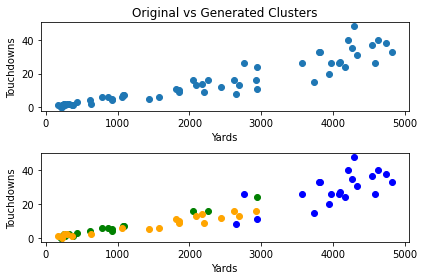

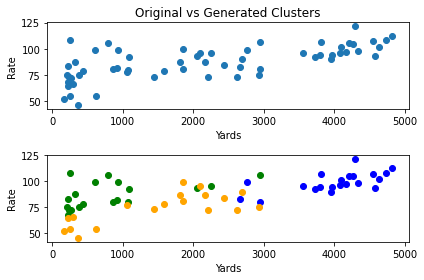

In [178]:
new_qbs = passing.reset_index()
new_qbs['Cluster'] = pd.Series(pred_qbs)

fig = plt.figure()    
fig.suptitle('Vertically stacked subplots')
fig,(ax1, ax2) = plt.subplots(2, sharex=False, sharey = False)

# Data Distribution
ax1.scatter(QBs["Yds"],QBs["TD"])
ax1.set_xlabel('Yards')
ax1.set_ylabel('Touchdowns')
ax1.set_title('Original vs Generated Clusters')

# Clusters
color=['blue','green','orange']
for k in range(0,3):
    data = new_qbs[new_qbs["Cluster"]==k]
    ax2.scatter(data["Yds"],data["TD"],c=color[k])
ax2.set_xlabel('Yards')
ax2.set_ylabel('Touchdowns')
fig.tight_layout()
plt.show()

fig,(ax3, ax4) = plt.subplots(2, sharex=False, sharey = False)

ax3.scatter(QBs["Yds"],QBs["Rate"])
ax3.set_xlabel('Yards')
ax3.set_ylabel('Rate')
ax3.set_title('Original vs Generated Clusters')

# Clusters
color=['blue','green','orange']
for k in range(0,3):
    data = new_qbs[new_qbs["Cluster"]==k]
    ax4.scatter(data["Yds"],data["Rate"],c=color[k])
ax4.set_xlabel('Yards')
ax4.set_ylabel('Rate')
fig.tight_layout()
plt.show()

In [179]:
new_qbs.head()

,index,Rk,Player,Tm,Age,Pos,G,GS,Cmp,Att,...,Y/C,Y/G,Rate,QBR,Sk,Sack Yds,Sk%,NY/A,ANY/A,Cluster
0,0,24,Cam Newton,NWE,31,QB,15,15,242,368,...,11.0,177.1,82.9,47.0,31,195,7.8,6.17,5.44,0
1,1,46,Jeff Driskel,DEN,27,NaN,3,1,35,64,...,12.3,144.0,78.4,43.4,11,98,14.7,4.45,4.05,1
2,2,25,Carson Wentz,PHI,28,QB,12,12,251,437,...,10.4,218.3,72.8,49.6,50,326,10.3,4.71,3.98,2
3,3,1,Deshaun Watson,HOU,25,QB,16,16,382,544,...,12.6,301.4,112.4,70.5,49,293,8.3,7.64,8.22,0
4,4,5,Josh Allen,BUF,24,QB,16,16,396,572,...,11.5,284.0,107.2,81.7,26,159,4.3,7.33,7.82,0


#### Running Back Clusters

In [180]:
new_rbs = rushing.reset_index()
new_rbs['Cluster'] = pd.Series(pred_rbs)
new_rbs.head()

,index,Rk,Player,Tm,Age,Pos,G,GS,Att,Yds,TD,1D,Lng,Y/A,Y/G,Fmb,Cluster
0,0,20.0,Mike Davis,CAR,27.0,RB,15.0,12.0,165.0,642.0,6.0,38.0,25.0,3.9,42.8,1.0,0
1,1,7.0,Kenyan Drake,ARI,26.0,RB,15.0,13.0,239.0,955.0,10.0,59.0,69.0,4.0,63.7,3.0,0
2,2,5.0,Ezekiel Elliott,DAL,25.0,RB,15.0,15.0,244.0,979.0,6.0,62.0,31.0,4.0,65.3,6.0,0
3,3,23.0,Adrian Peterson,DET,35.0,RB,16.0,10.0,156.0,604.0,7.0,34.0,38.0,3.9,37.8,0.0,0
4,4,80.0,Matt Breida,MIA,25.0,NaN,12.0,1.0,59.0,254.0,0.0,11.0,24.0,4.3,21.2,2.0,2


<Figure size 432x288 with 0 Axes>

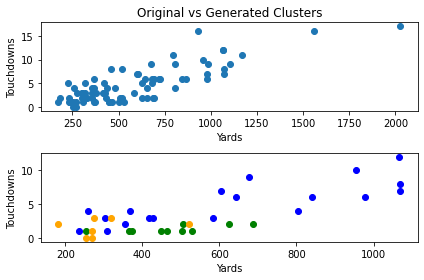

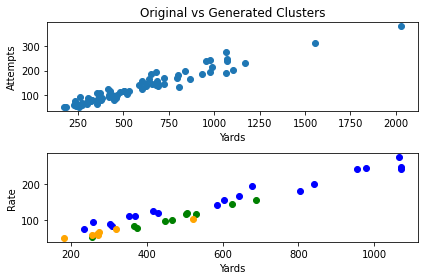

In [181]:
fig = plt.figure()    
fig.suptitle('Vertically stacked subplots')
fig,(ax1, ax2) = plt.subplots(2, sharex=False, sharey = False)

# Data Distribution
ax1.scatter(RBs["Yds"],RBs["TD"])
ax1.set_xlabel('Yards')
ax1.set_ylabel('Touchdowns')
ax1.set_title('Original vs Generated Clusters')

# Clusters
color=['blue','green','orange']
for k in range(0,3):
    data = new_rbs[new_rbs["Cluster"]==k]
    ax2.scatter(data["Yds"],data["TD"],c=color[k])
ax2.set_xlabel('Yards')
ax2.set_ylabel('Touchdowns')
fig.tight_layout()
plt.show()

fig,(ax3, ax4) = plt.subplots(2, sharex=False, sharey = False)

ax3.scatter(RBs["Yds"],RBs["Att"])
ax3.set_xlabel('Yards')
ax3.set_ylabel('Attempts')
ax3.set_title('Original vs Generated Clusters')

# Clusters
color=['blue','green','orange']
for k in range(0,3):
    data = new_rbs[new_rbs["Cluster"]==k]
    ax4.scatter(data["Yds"],data["Att"],c=color[k])
ax4.set_xlabel('Yards')
ax4.set_ylabel('Rate')
fig.tight_layout()
plt.show()

#### Wide Receiver and Tight End Clusters

In [182]:
new_wr_te = receiving.reset_index()
new_wr_te['Cluster'] = pd.Series(pred_wr_te)
new_wr_te.head()

,index,Rk,Player,Tm,Age,Pos,G,GS,Tgt,Rec,...,Yds,Y/R,TD,1D,Lng,Y/Tgt,R/G,Y/G,Fmb,Cluster
0,0,54,Mark Andrews,BAL,25,NaN,14,2,88,58,...,701,12.1,7,37,39,8.0,4.1,50.1,2,3
1,1,34,Tee Higgins,CIN,21,WR,16,14,108,67,...,908,13.6,6,52,67,8.4,4.2,56.8,1,1
2,2,78,Kendrick Bourne,SFO,25,wr,15,5,74,49,...,667,13.6,2,35,49,9.0,3.3,44.5,0,1
3,3,1,Stefon Diggs,BUF,27,WR,16,15,166,127,...,1535,12.1,8,73,55,9.2,7.9,95.9,0,4
4,4,120,Tyler Eifert,JAX,30,NaN,15,4,60,36,...,349,9.7,2,22,28,5.8,2.4,23.3,0,1


<Figure size 432x288 with 0 Axes>

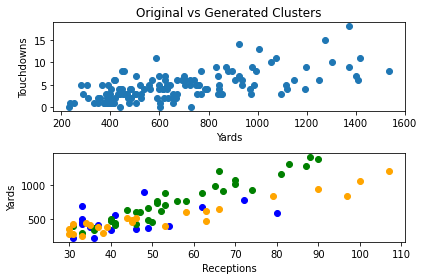

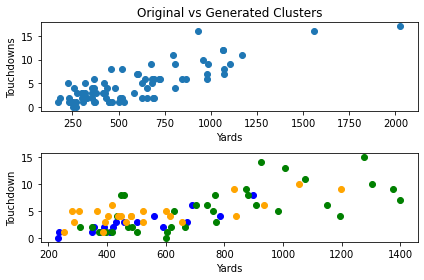

In [183]:
fig = plt.figure()    
fig.suptitle('Vertically stacked subplots')
fig,(ax1, ax2) = plt.subplots(2, sharex=False, sharey = False)

# Data Distribution
ax1.scatter(WR_TE["Yds"],WR_TE["TD"])
ax1.set_xlabel('Yards')
ax1.set_ylabel('Touchdowns')
ax1.set_title('Original vs Generated Clusters')

# Clusters
color=['blue','green','orange']
for k in range(0,3):
    data = new_wr_te[new_wr_te["Cluster"]==k]
    ax2.scatter(data["Rec"],data["Yds"],c=color[k])
ax2.set_xlabel('Receptions')
ax2.set_ylabel('Yards')
fig.tight_layout()
plt.show()

fig,(ax3, ax4) = plt.subplots(2, sharex=False, sharey = False)

ax3.scatter(RBs["Yds"],RBs["TD"])
ax3.set_xlabel('Yards')
ax3.set_ylabel('Touchdowns')
ax3.set_title('Original vs Generated Clusters')

# Clusters
color=['blue','green','orange']
for k in range(0,3):
    data = new_wr_te[new_wr_te["Cluster"]==k]
    ax4.scatter(data["Yds"],data["TD"],c=color[k])
ax4.set_xlabel('Yards')
ax4.set_ylabel('Touchdown')
fig.tight_layout()
plt.show()

### Scikit-Learn Gaussian Mixture Model Comparison

Below, I will print the Quarterback clusters (in this example, 3) for both the Gaussian model that I created as well as the Scikit-Learn Gaussian model. 

<Figure size 432x288 with 0 Axes>

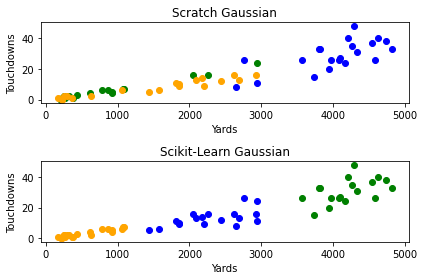

<Figure size 432x288 with 0 Axes>

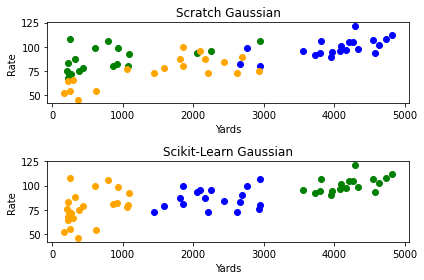

In [184]:
from sklearn.mixture import GaussianMixture
gmm_scikit = GaussianMixture(n_components=3).fit(array_qbs)
labels = gmm_scikit.predict(array_qbs)

scikit_qbs = passing.reset_index()
scikit_qbs['Cluster'] = pd.Series(labels)
scikit_qbs

fig = plt.figure()    
fig,(ax1, ax2) = plt.subplots(2, sharex=False, sharey = False)

# Clusters
ax1.set_title('Scratch Gaussian')
color=['blue','green','orange']
for k in range(0,3):
    data = new_qbs[new_qbs["Cluster"]==k]
    ax1.scatter(data["Yds"],data["TD"],c=color[k])
ax1.set_xlabel('Yards')
ax1.set_ylabel('Touchdowns')

# Clusters
ax2.set_title('Scikit-Learn Gaussian')
color=['blue','green','orange']
for k in range(0,3):
    data = scikit_qbs[scikit_qbs["Cluster"]==k]
    ax2.scatter(data["Yds"],data["TD"],c=color[k])
ax2.set_xlabel('Yards')
ax2.set_ylabel('Touchdowns')

fig.tight_layout()

plt.show()

fig = plt.figure()    
fig,(ax1, ax2) = plt.subplots(2, sharex=False, sharey = False)

# Clusters
ax1.set_title('Scratch Gaussian')
color=['blue','green','orange']
for k in range(0,3):
    data = new_qbs[new_qbs["Cluster"]==k]
    ax1.scatter(data["Yds"],data["Rate"],c=color[k])
ax1.set_xlabel('Yards')
ax1.set_ylabel('Rate')

# Clusters
ax2.set_title('Scikit-Learn Gaussian')
color=['blue','green','orange']
for k in range(0,3):
    data = scikit_qbs[scikit_qbs["Cluster"]==k]
    ax2.scatter(data["Yds"],data["Rate"],c=color[k])
ax2.set_xlabel('Yards')
ax2.set_ylabel('Rate')

fig.tight_layout()

plt.show()

Currently, as you can see, Scikit-Learn has generated clusters that are much more distinct. This is not ideal as we would like these two graphs to be as close as possible. With this, we are only displaying two of the three features, however, our model may be placing too much value on the 'Rate' feature. With rate, a Quarterback could have a very low number of yards and touchdowns but have a high rate due to a high completion percentage. Let's compare the actual Dateframes and see if we can undercover what may be causing the differences. 

In [185]:
scikit_qbs.sort_values(by = 'Rk').head(15)

,index,Rk,Player,Tm,Age,Pos,G,GS,Cmp,Att,...,Y/C,Y/G,Rate,QBR,Sk,Sack Yds,Sk%,NY/A,ANY/A,Cluster
3,3,1,Deshaun Watson,HOU,25,QB,16,16,382,544,...,12.6,301.4,112.4,70.5,49,293,8.3,7.64,8.22,1
17,17,2,Patrick Mahomes,KAN,25,QB,15,15,390,588,...,12.2,316.0,108.2,82.9,22,147,3.6,7.53,8.33,1
24,24,3,Tom Brady,TAM,43,QB,16,16,401,610,...,11.6,289.6,102.2,72.5,21,143,3.3,7.12,7.53,1
21,21,4,Matt Ryan,ATL,35,QB,16,16,407,626,...,11.3,286.3,93.3,67.0,41,257,6.1,6.48,6.52,1
4,4,5,Josh Allen,BUF,24,QB,16,16,396,572,...,11.5,284.0,107.2,81.7,26,159,4.3,7.33,7.82,1
18,18,6,Justin Herbert,LAC,22,QB,15,15,396,595,...,10.9,289.1,98.3,69.5,32,218,5.1,6.57,6.84,1
11,11,7,Aaron Rodgers,GNB,37,QB,16,16,372,526,...,11.6,268.7,121.5,84.4,20,182,3.7,7.54,8.89,1
54,54,8,Kirk Cousins,MIN,32,QB,16,16,349,516,...,12.2,266.6,105.0,63.2,39,256,7.0,7.22,7.43,1
47,47,9,Russell Wilson,SEA,32,QB,16,16,384,558,...,11.0,263.3,105.1,73.5,47,301,7.8,6.46,6.82,1
16,16,10,Philip Rivers,IND,39,QB,16,16,369,543,...,11.3,260.6,97.0,62.5,19,118,3.4,7.21,7.18,1


In [186]:
new_qbs.sort_values(by = 'Rk').head(15)

,index,Rk,Player,Tm,Age,Pos,G,GS,Cmp,Att,...,Y/C,Y/G,Rate,QBR,Sk,Sack Yds,Sk%,NY/A,ANY/A,Cluster
3,3,1,Deshaun Watson,HOU,25,QB,16,16,382,544,...,12.6,301.4,112.4,70.5,49,293,8.3,7.64,8.22,0
17,17,2,Patrick Mahomes,KAN,25,QB,15,15,390,588,...,12.2,316.0,108.2,82.9,22,147,3.6,7.53,8.33,0
24,24,3,Tom Brady,TAM,43,QB,16,16,401,610,...,11.6,289.6,102.2,72.5,21,143,3.3,7.12,7.53,0
21,21,4,Matt Ryan,ATL,35,QB,16,16,407,626,...,11.3,286.3,93.3,67.0,41,257,6.1,6.48,6.52,0
4,4,5,Josh Allen,BUF,24,QB,16,16,396,572,...,11.5,284.0,107.2,81.7,26,159,4.3,7.33,7.82,0
18,18,6,Justin Herbert,LAC,22,QB,15,15,396,595,...,10.9,289.1,98.3,69.5,32,218,5.1,6.57,6.84,0
11,11,7,Aaron Rodgers,GNB,37,QB,16,16,372,526,...,11.6,268.7,121.5,84.4,20,182,3.7,7.54,8.89,0
54,54,8,Kirk Cousins,MIN,32,QB,16,16,349,516,...,12.2,266.6,105.0,63.2,39,256,7.0,7.22,7.43,0
47,47,9,Russell Wilson,SEA,32,QB,16,16,384,558,...,11.0,263.3,105.1,73.5,47,301,7.8,6.46,6.82,0
16,16,10,Philip Rivers,IND,39,QB,16,16,369,543,...,11.3,260.6,97.0,62.5,19,118,3.4,7.21,7.18,0


In general, using only 3 clusters in this example, I expected these quarterbacks to all be in one cluster based on how far the number of attempts, yards, touchdowns and quarterback rate compares to those of the other two tiers. Without a deeper investigation, I would assume that the lower 'Rate' for Matt Ryan, Phillip Rivers and Jared Goff were placed in a lower tier. However, we are comparing the scikit-learn versus from scratch model using the same features so this shouldn't be the case.